In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import numpy as np
import torch as ch
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, StopStringCriteria, StoppingCriteriaList, DataCollatorForSeq2Seq
from matplotlib import pyplot as plt

In [3]:
from hot_pate.samplers import IndependentSampler, CoordinatedSampler
from hot_pate.aggregators import MaxAggregator
from hot_pate.utils import create_histograms, estimate_transfer_support, estimate_transfer_mass, get_model_and_tokenizer, load_instruction_dataset, create_instruction_teacher_prompts, create_stop_fn
from hot_pate.hot_pate import *

In [4]:
NUM_TEACHERS = 512
NUM_EXAMPLES_PER_TEACHER = 10

model_name = "meta-llama/Llama-3.1-8B"
model, tokenizer = get_model_and_tokenizer(model_name)
dataset = load_instruction_dataset()
teacher_prompts = create_instruction_teacher_prompts(
    dataset, NUM_TEACHERS, NUM_EXAMPLES_PER_TEACHER, seed=0
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
ind_sampler = IndependentSampler(temperature=0.6)
coo_sampler = CoordinatedSampler(temperature=0.6)

In [6]:
def draw_support_table(
    ax,
    ind_token_texts,
    coo_token_texts,
    *,
    fontsize: int = 10,
    header_frac: float = 0.125,
    max_length: int = 13,
):
    ax.axis("off")

    def prepare_text(token_texts):
        if len(token_texts) <= max_length:
            return "\n".join(f"{i + 1}. {tok!r}" for i, tok in enumerate(token_texts)) + "\n" * (max_length - len(token_texts))
        else:
            return "\n".join(f"{i + 1}. {tok!r}" for i, tok in enumerate(token_texts[:max_length - 1])) + f"\n ... {len(token_texts) - max_length + 1} more"

    ind_text = prepare_text(ind_token_texts)
    coo_text = prepare_text(coo_token_texts)
    cell_text = [
        ["Independent", "Coordinated"],
        [ind_text,       coo_text    ],
    ]
    cell_colours = [
        ["tab:blue", "tab:orange"],
        ["white",    "white"     ],
    ]
    table = ax.table(
        cellText=cell_text,
        cellColours=cell_colours,
        cellLoc="left",
        loc="center",
        bbox=[0, 0, 1, 1],
    )
    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    bottom_frac = 1.0 - header_frac
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(color="white", weight="bold", ha="center")
            cell.set_height(header_frac)
        else:
            cell.set_height(bottom_frac)
            cell.set_text_props(va="center")
    return table

In [7]:
THRESHOLDS = 2 ** np.linspace(5, 8, 20)


def show_transferred_diversity(
    ind_histograms, coo_histograms, prefix, save_path=None, thresholds=THRESHOLDS
):
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 1, 0.75]}
    )
    supports = defaultdict(dict)
    for threshold in thresholds:
        supports["independent"][threshold] = estimate_transfer_support(
            ind_histograms, threshold
        )
        supports["coordinated"][threshold] = estimate_transfer_support(
            coo_histograms, threshold
        )
    ax1.plot(
        thresholds,
        [len(supports["independent"][threshold]) for threshold in thresholds],
        marker="o",
        label="Independent",
    )
    ax1.plot(
        thresholds,
        [len(supports["coordinated"][threshold]) for threshold in thresholds],
        marker="o",
        label="Coordinated",
    )
    ax1.set_xlabel("Threshold")
    ax1.set_title("Transferred support size")
    ax1.grid()
    ax1.legend()
    masses = defaultdict(dict)
    for threshold in thresholds:
        masses["independent"][threshold] = estimate_transfer_mass(
            ind_histograms, threshold
        )
        masses["coordinated"][threshold] = estimate_transfer_mass(
            coo_histograms, threshold
        )
    ax2.plot(
        thresholds,
        [masses["independent"][threshold] for threshold in thresholds],
        marker="o",
        label="Independent",
    )
    ax2.plot(
        thresholds,
        [masses["coordinated"][threshold] for threshold in thresholds],
        marker="o",
        label="Coordinated",
    )
    ax2.set_xlabel("Threshold")
    ax2.set_title("Transferred probability mass")
    ax2.grid()
    display_threshold = thresholds[-1]
    ind_tokens = supports["independent"][display_threshold]
    coo_tokens = supports["coordinated"][display_threshold]
    ind_token_texts = [tokenizer.decode(token) for token in list(ind_tokens)]
    coo_token_texts = [tokenizer.decode(token) for token in list(coo_tokens)]
    draw_support_table(ax3, ind_token_texts, coo_token_texts)
    ax3.set_title(rf"Supported tokens ($T = {display_threshold:.0f}$)")
    formatted_prefix = prefix if len(prefix) > 0 else r"$\O$"
    fig.suptitle(
        f'Transferred diversity when generating an instruction from "{formatted_prefix}"',
        fontsize=13,
    )
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Evaluating teachers:   0%|          | 0/16 [00:00<?, ?it/s]

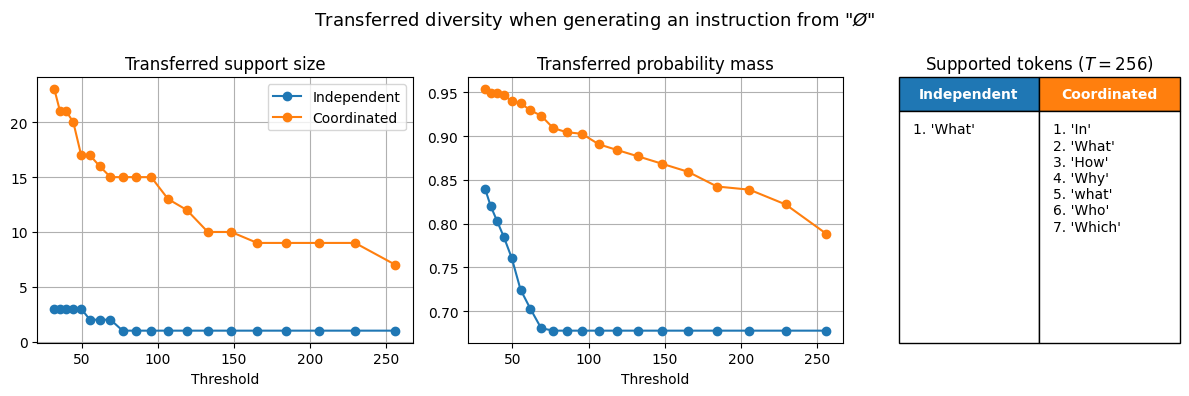

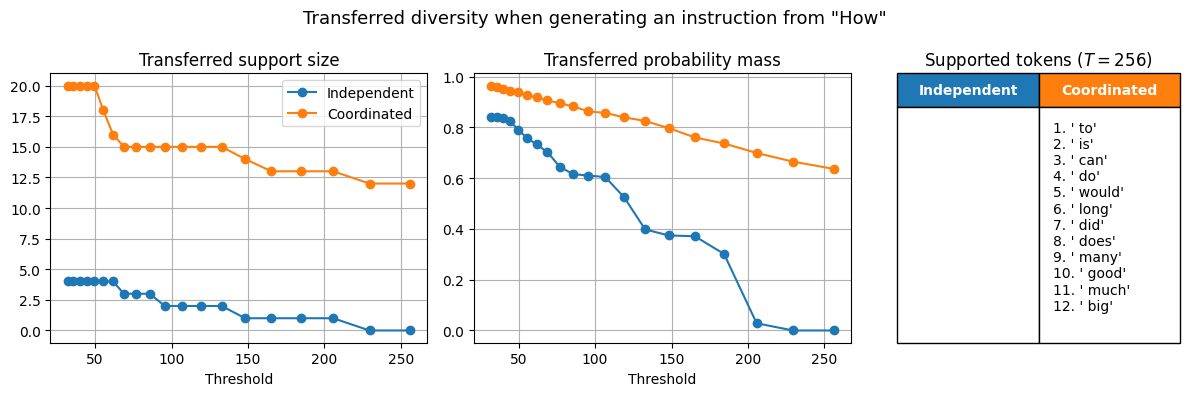

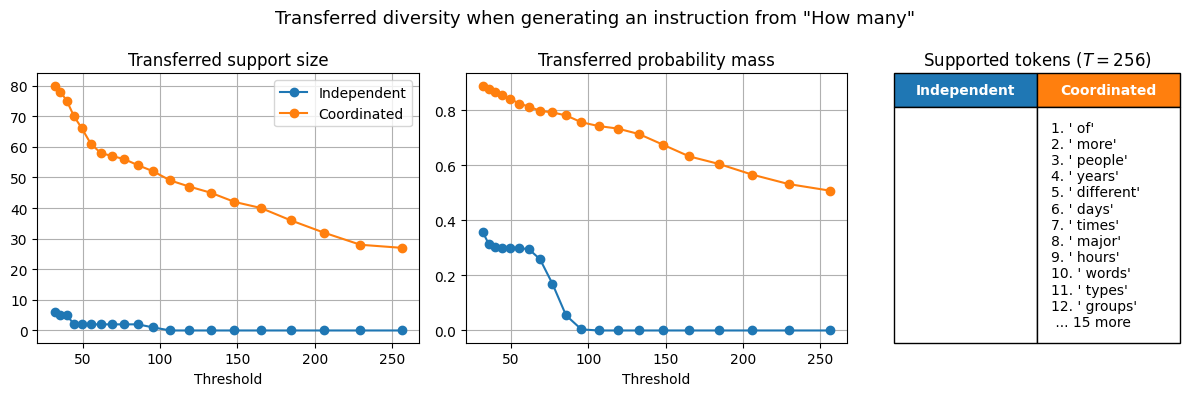

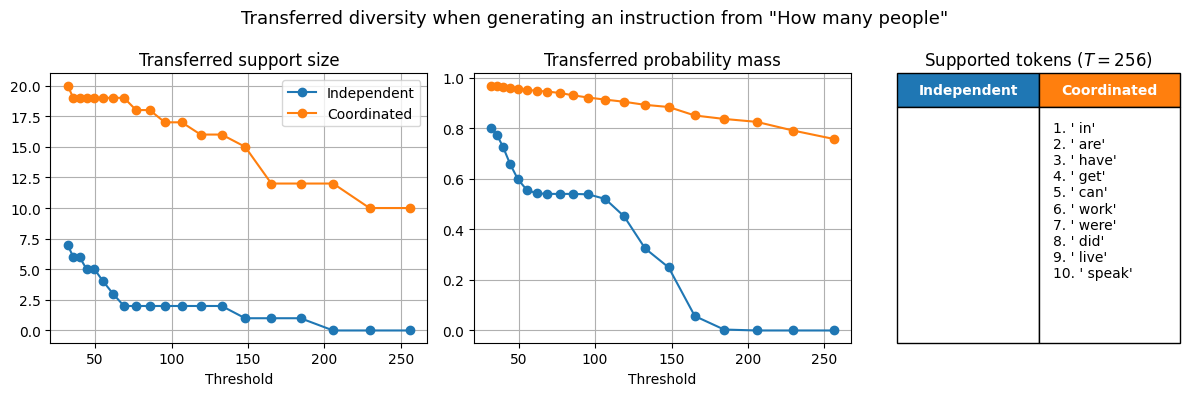

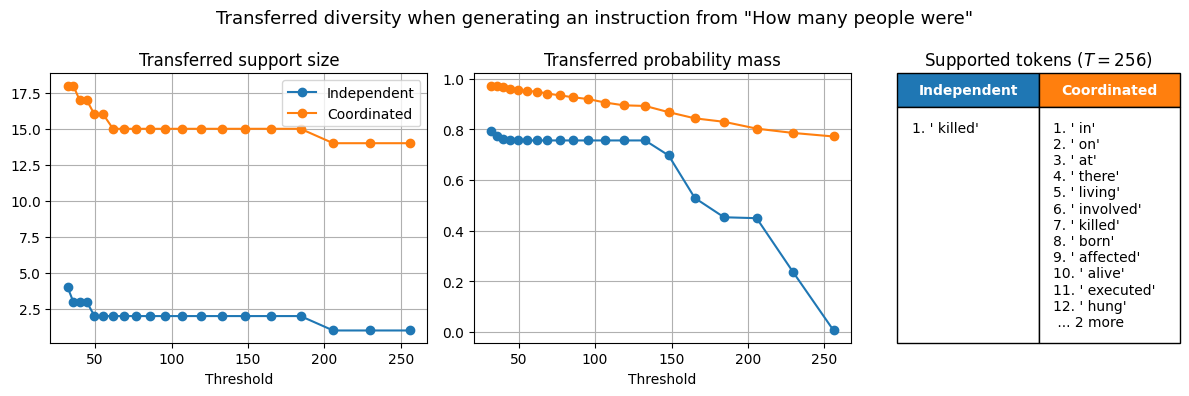

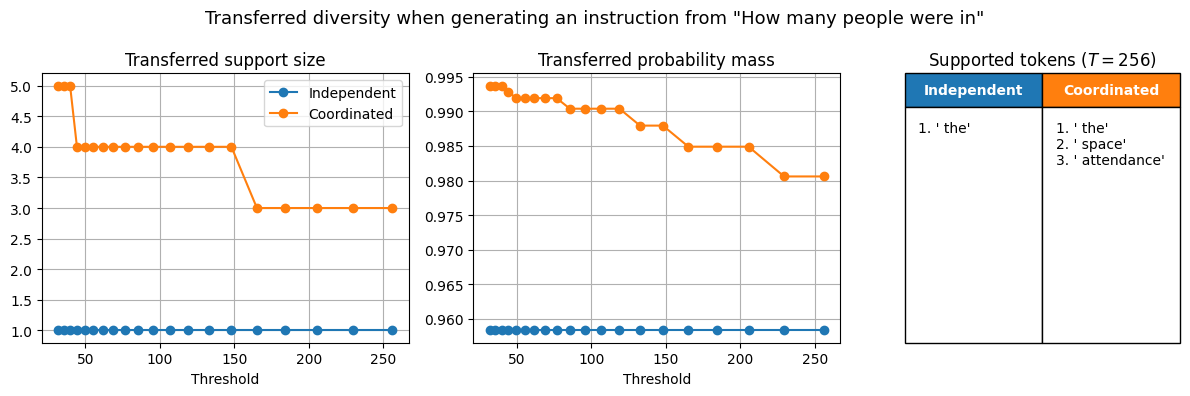

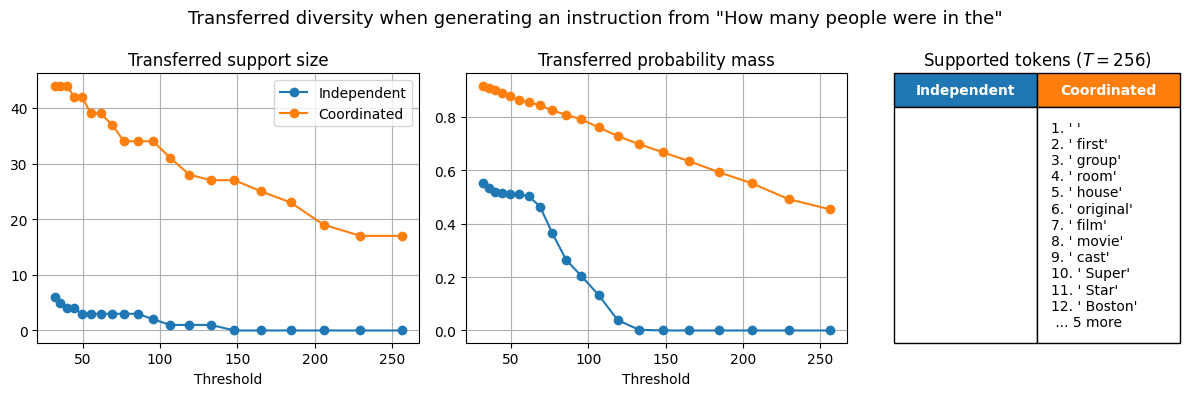

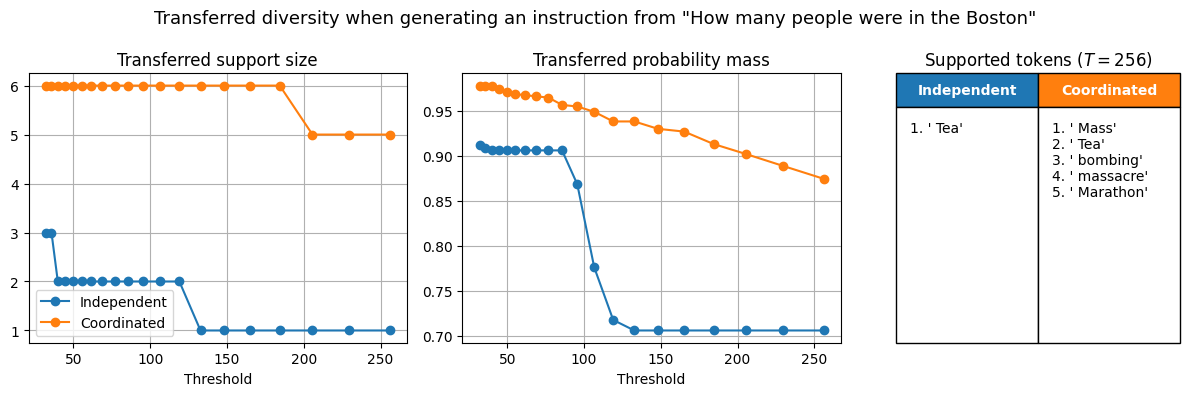

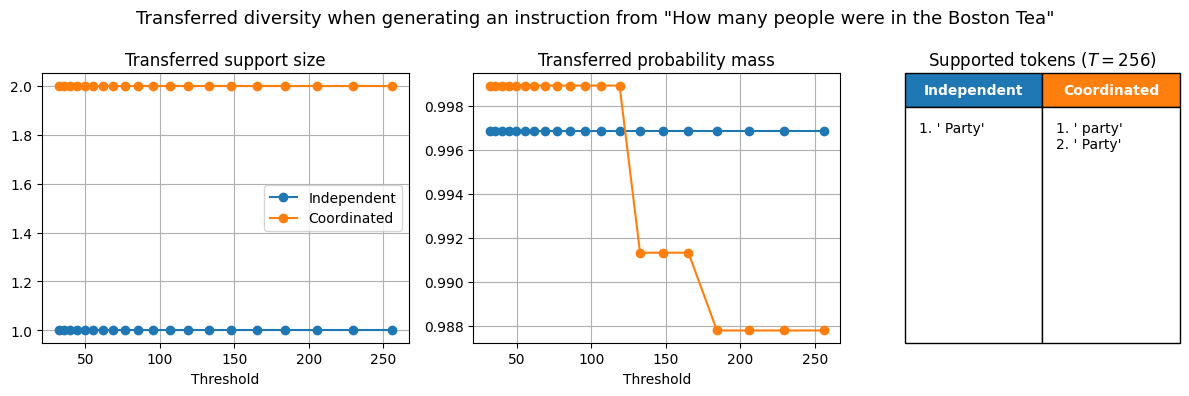

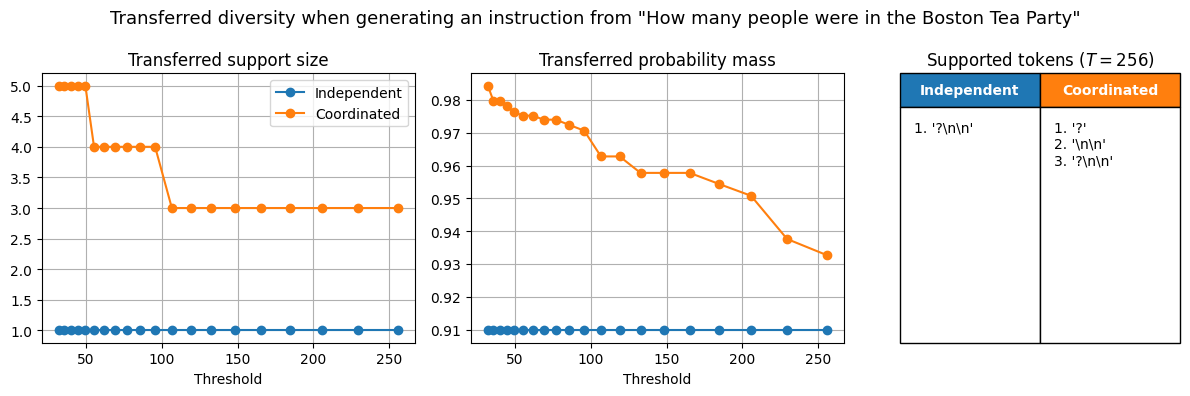

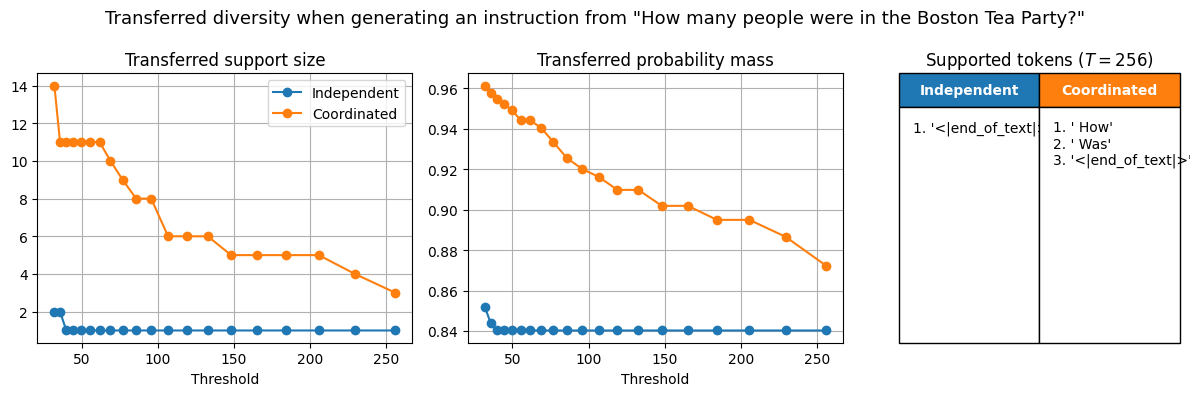

In [9]:
num_samples = 100
stop_fn = create_stop_fn(tokenizer)
prompt_dict = initialize_prompt_dict(teacher_prompts, tokenizer)
logits = compute_logits(prompt_dict, model, tokenizer, verbose=True)

save_path = Path("outputs") / "diversity_transfer"
save_path.mkdir(parents=True, exist_ok=True)
generated_tokens = []
prev_generation = ""
with ch.no_grad():
    step = 0
    while not stop_fn(generated_tokens):
        logits = compute_logits(prompt_dict, model, tokenizer)

        _, vocab_size = logits.shape
        ind_samples = ind_sampler.sample(logits, num_samples=num_samples)
        ind_histograms = create_histograms(ind_samples, vocab_size)
        coo_samples = coo_sampler.sample(logits, num_samples=num_samples)
        coo_histograms = create_histograms(coo_samples, vocab_size)
        cur_save_path = save_path / f"step_{step}.pdf"
        show_transferred_diversity(
            ind_histograms, coo_histograms, prev_generation, save_path=cur_save_path
        )

        probs = logits_to_probs(logits).mean(dim=0)
        token = ch.multinomial(probs, num_samples=1).item()
        generated_tokens.append(token)
        update_prompt_dict(prompt_dict, token)
        cur_generation = tokenizer.decode(generated_tokens)
        prev_generation = cur_generation
        step += 1